# BT4012 Project: Model Building, Tuning, and Evaluation
### Completed by: Group 8

# Import Packages

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Initialize the evaluator
from model_evaluator import ModelEvaluator
evaluator = ModelEvaluator()

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

# Global Variables
RANDOM_STATE = 42

# Load Datasets & Basic EDA

#### Train set

In [2]:
train_df = pd.read_csv('../data/processed/train.csv')
train_df.head()

,trans_timeofday_night,amt,dist_from_last_trans,merchant,time_since_last_trans,trans_hour,trans_isworkhours,transaction_velocity,is_fraud
0,1.0,0.000011,0.214939,0.002540,0.004717,1.000000,0,8.558783e-06,0
1,0.0,0.000508,0.579818,0.002287,0.016741,0.652174,1,6.505197e-06,0
2,0.0,0.000631,0.534537,0.001380,0.026992,0.695652,1,3.719519e-06,0
3,0.0,0.005356,0.242022,0.001711,0.089617,0.434783,1,5.072255e-07,0
4,0.0,0.014015,0.671043,0.003447,0.004334,0.347826,1,2.908067e-05,0


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232668 entries, 0 to 232667
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_timeofday_night  232668 non-null  float64
 1   amt                    232668 non-null  float64
 2   dist_from_last_trans   232668 non-null  float64
 3   merchant               232668 non-null  float64
 4   time_since_last_trans  232668 non-null  float64
 5   trans_hour             232668 non-null  float64
 6   trans_isworkhours      232668 non-null  int64  
 7   transaction_velocity   232668 non-null  float64
 8   is_fraud               232668 non-null  int64  
dtypes: float64(7), int64(2)
memory usage: 16.0 MB


#### Validation set

In [4]:
validation_df = pd.read_csv('../data/processed/validation.csv')
validation_df.head()

,trans_timeofday_night,amt,dist_from_last_trans,merchant,time_since_last_trans,trans_hour,trans_isworkhours,transaction_velocity,is_fraud
0,0.0,0.018751,0.360518,0.000808,0.204182,0.608696,1,3.316271e-07,0
1,1.0,0.000370,0.587510,0.000830,0.043286,0.913043,0,2.549209e-06,0
2,1.0,0.000746,0.427590,0.001023,0.024188,1.000000,0,3.320280e-06,0
3,0.0,0.000356,0.442112,0.003180,0.369554,0.608696,1,2.246955e-07,0
4,0.0,0.000128,0.487675,0.001092,0.026658,0.565217,1,3.435940e-06,0


In [5]:
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trans_timeofday_night  30000 non-null  float64
 1   amt                    30000 non-null  float64
 2   dist_from_last_trans   30000 non-null  float64
 3   merchant               30000 non-null  float64
 4   time_since_last_trans  30000 non-null  float64
 5   trans_hour             30000 non-null  float64
 6   trans_isworkhours      30000 non-null  int64  
 7   transaction_velocity   30000 non-null  float64
 8   is_fraud               30000 non-null  int64  
dtypes: float64(7), int64(2)
memory usage: 2.1 MB


#### Test set

In [6]:
test_df = pd.read_csv('../data/processed/test.csv')
test_df.head()

,trans_timeofday_night,amt,dist_from_last_trans,merchant,time_since_last_trans,trans_hour,trans_isworkhours,transaction_velocity,is_fraud
0,0.0,0.002465,0.216631,0.000765,0.057390,0.521739,1,7.089662e-07,0
1,0.0,0.013654,0.308795,0.002794,0.105005,0.217391,0,5.523297e-07,0
2,0.0,0.003374,0.225573,0.000408,0.028884,0.217391,0,1.466775e-06,0
3,0.0,0.005874,0.401045,0.000830,0.091167,0.782609,1,8.262200e-07,0
4,0.0,0.002706,0.624411,0.001057,0.045945,0.565217,1,2.552510e-06,0


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trans_timeofday_night  30000 non-null  float64
 1   amt                    30000 non-null  float64
 2   dist_from_last_trans   30000 non-null  float64
 3   merchant               30000 non-null  float64
 4   time_since_last_trans  30000 non-null  float64
 5   trans_hour             30000 non-null  float64
 6   trans_isworkhours      30000 non-null  int64  
 7   transaction_velocity   30000 non-null  float64
 8   is_fraud               30000 non-null  int64  
dtypes: float64(7), int64(2)
memory usage: 2.1 MB


#### Splitting into X and y

In [8]:
# split train df, validation df, test df into each of their X and y
y_train = train_df.pop('is_fraud')
X_train = train_df

y_valid = validation_df.pop('is_fraud')
X_valid = validation_df

y_test = test_df.pop('is_fraud')
X_test = test_df

In [9]:
X_train

,trans_timeofday_night,amt,dist_from_last_trans,merchant,time_since_last_trans,trans_hour,trans_isworkhours,transaction_velocity
0,1.0,0.000011,0.214939,0.002540,0.004717,1.000000,0,8.558783e-06
1,0.0,0.000508,0.579818,0.002287,0.016741,0.652174,1,6.505197e-06
2,0.0,0.000631,0.534537,0.001380,0.026992,0.695652,1,3.719519e-06
3,0.0,0.005356,0.242022,0.001711,0.089617,0.434783,1,5.072255e-07
4,0.0,0.014015,0.671043,0.003447,0.004334,0.347826,1,2.908067e-05
...,...,...,...,...,...,...,...,...
232663,1.0,0.000378,0.000000,0.000636,0.000000,0.130435,0,0.000000e+00
232664,1.0,0.056439,0.000000,0.001517,0.000000,0.130435,0,0.000000e+00
232665,0.0,0.018976,0.000000,0.004169,0.000000,0.782609,1,0.000000e+00
232666,1.0,0.075326,0.000000,0.003099,0.000000,1.000000,0,0.000000e+00


# Model Building & Hyperparameter Tuning

### Steps
- Choose a model: LogisticRegression, RidgeClassifier, SGDClassifier, KNeighborsClassifier, SVC, GaussianNB, DecisionTreeClassifier, HistGradientBoostingClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier, AdaBoostClassifier, XGBClassifier
- Fit the model to the train set
- Get model's predictions for the train and validation set
- Compare the accuracy scores for the validation set and train set to detect overfitting
- Do k-fold cross validation and hyperparameter tuning: GridSearchCV, RandomizedSearchCV
- Repeat the steps above for other models

#### Baseline Model (DummyClassifier with 'prior' strategy)
DummyClassifier that will always predict the most frequent class label

In [10]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="prior", random_state=42)
dummy_clf.fit(X_train, y_train)

DummyClassifier(random_state=42)

In [11]:
# evaluate model performance on the validation set for hyperparameter tuning
y_valpred_dummy = dummy_clf.predict(X_valid)
y_valpred_prob_dummy = dummy_clf.predict_proba(X_valid)[:, 1]

evaluator.evaluate_model(
    model_name="Baseline Model",
    y_actual=y_valid,
    y_pred=y_valpred_dummy,
    y_pred_prob=y_valpred_prob_dummy,
    dataset_name="Validation"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
Baseline Model,0.9942,0.0,0.0,0.0,0.5,0.0058


#### Logistic Regression

In [12]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform, randint

# create parameter grid
logreg_param_l1l2 = {
    'C': uniform(0.001, 10.0),
    'penalty': ['l1', 'l2'],
    'solver': ['saga'],
    'max_iter': [1000],
    'class_weight': ['balanced', None]
}

logreg_param_elasticnet = {
    'C': uniform(0.001, 10.0),
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'l1_ratio': uniform(0, 1),
    'max_iter': [1000],
    'class_weight': ['balanced', None]
}

logreg_param_distributions = [logreg_param_l1l2, logreg_param_elasticnet]

# create model and perform randomized search
logreg_clf = LogisticRegression(random_state=42)

logreg_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
logreg_random_search = RandomizedSearchCV(
    logreg_clf, param_distributions=logreg_param_distributions,
    n_iter=50, cv=logreg_cv, scoring='roc_auc',
    random_state=42, n_jobs=-1
)

# fit model to train set
logreg_random_search.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The ma

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=LogisticRegression(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions=[{'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x16b89a830>,
                                         'class_weight': ['balanced', None],
                                         'max_iter': [1000],
                                         'penalty': ['l1', 'l2'],
                                         'solver': ['saga']},
                                        {'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x16b89b7f0>,
                                         'class_weight': ['balanced', None],
                                         'l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x173d01d50>,
                                         'max_iter': [1000],
                                         'penalty': ['elasticnet'],
                                         'solver': ['saga']}],
                   random_state=42, scoring='roc_auc')

In [13]:
# evaluate model performance on the validation set for hyperparameter tuning
y_valpred_logreg = logreg_random_search.best_estimator_.predict(X_valid)
y_valpred_prob_logreg = logreg_random_search.best_estimator_.predict_proba(X_valid)[:, 1]

evaluator.evaluate_model(
    model_name="LogisticRegression",
    y_actual=y_valid,
    y_pred=y_valpred_logreg,
    y_pred_prob=y_valpred_prob_logreg,
    dataset_name="Validation"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
LogisticRegression,0.957067,0.043443,0.304598,0.07604,0.6365,0.094327


#### SGDClassifier

In [14]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import uniform, randint

# create parameter grid
sgd_param_distributions = {
    'loss': ['log_loss', 'modified_huber'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'alpha': uniform(1e-5, 1),
    'l1_ratio': uniform(0, 1),
    'max_iter': [1000],
    'learning_rate': ['optimal', 'adaptive'],
    'class_weight': ['balanced', None]
}

# create model and perform randomized search
sgd_clf = SGDClassifier(random_state=42)

sgd_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
sgd_random_search = RandomizedSearchCV(
    sgd_clf, param_distributions=sgd_param_distributions,
    n_iter=50, cv=sgd_cv, scoring='roc_auc',
    random_state=42, n_jobs=-1
)

# fit model to train set
sgd_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=SGDClassifier(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x173d02860>,
                                        'class_weight': ['balanced', None],
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x16b89b0a0>,
                                        'learning_rate': ['optimal',
                                                          'adaptive'],
                                        'loss': ['log_loss', 'modified_huber'],
                                        'max_iter': [1000],
                                        'penalty': ['l1', 'l2', 'elasticnet']},
                   random_state=42, scoring='roc_auc')

In [15]:
# evaluate model performance on the validation set for hyperparameter tuning
y_valpred_sgd = sgd_random_search.best_estimator_.predict(X_valid)
y_valpred_prob_sgd = sgd_random_search.best_estimator_.predict_proba(X_valid)[:, 1]

evaluator.evaluate_model(
    model_name="SGDClassifier",
    y_actual=y_valid,
    y_pred=y_valpred_sgd,
    y_pred_prob=y_valpred_prob_sgd,
    dataset_name="Validation"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
SGDClassifier,0.885167,0.018829,0.367816,0.035824,0.729398,0.08384


#### RidgeClassifier

In [20]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import uniform, randint

# create parameter grid
ridge_param_distributions = {
    'alpha': uniform(0.1, 10.0),
    'class_weight': ['balanced', None]
}

# create model and perform randomized search
ridge_clf = RidgeClassifier(random_state=42)

ridge_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
ridge_random_search = RandomizedSearchCV(
    ridge_clf, param_distributions=ridge_param_distributions,
    n_iter=50, cv=ridge_cv, scoring='roc_auc',
    random_state=42, n_jobs=-1
)

# fit model to train set
ridge_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RidgeClassifier(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x173d3d300>,
                                        'class_weight': ['balanced', None]},
                   random_state=42, scoring='roc_auc')

In [22]:
# evaluate model performance on the validation set for hyperparameter tuning
y_valpred_ridge = ridge_random_search.best_estimator_.predict(X_valid)
y_valpred_dec_ridge = ridge_random_search.best_estimator_.decision_function(X_valid)

evaluator.evaluate_model(
    model_name="RidgeClassifier",
    y_actual=y_valid,
    y_pred=y_valpred_ridge,
    y_pred_prob=None,
    y_pred_dec=y_valpred_dec_ridge,
    dataset_name="Validation"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
RidgeClassifier,0.9453,0.042991,0.396552,0.077572,0.74105,0.100629


#### KNeighborsClassifier

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import uniform, randint

# create parameter grid
kneigh_param_distributions = {
    'n_neighbors': randint(2, 5),
    'weights': ['uniform', 'distance'],
    'p': randint(1, 3)
}

# create model and perform randomized search
kneigh_clf = KNeighborsClassifier()

kneigh_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kneigh_random_search = RandomizedSearchCV(
    kneigh_clf, param_distributions=kneigh_param_distributions,
    n_iter=50, cv=kneigh_cv, scoring='roc_auc',
    random_state=42, n_jobs=-1
)

# fit model to train set
kneigh_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=KNeighborsClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x173d3f610>,
                                        'p': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17f5c2590>,
                                        'weights': ['uniform', 'distance']},
                   random_state=42, scoring='roc_auc')

In [19]:
# evaluate model performance on the validation set for hyperparameter tuning
y_valpred_kneigh = kneigh_random_search.best_estimator_.predict(X_valid)
y_valpred_prob_kneigh = kneigh_random_search.best_estimator_.predict_proba(X_valid)[:, 1]

evaluator.evaluate_model(
    model_name="KNeighborsClassifier",
    y_actual=y_valid,
    y_pred=y_valpred_kneigh,
    y_pred_prob=y_valpred_prob_kneigh,
    dataset_name="Validation"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
KNeighborsClassifier,0.982833,0.12854,0.33908,0.186414,0.730066,0.077829


#### SVC

#### GaussianNB

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb_model = GaussianNB()

gnb_model.fit(X_train, y_train)

GaussianNB()

#### DecisionTreeClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

decisiontree_model = DecisionTreeClassifier(
    max_depth=5, 
    min_samples_split=2, 
    min_samples_leaf=4, 
    random_state=RANDOM_STATE
)

decisiontree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=4, random_state=42)

#### HistGradientBoostingClassifier

In [12]:
from sklearn.ensemble import HistGradientBoostingClassifier

# define the hyperparameter space
histgb_param_grid = {
    "learning_rate": (0.01, 0.1, 0.2),
    "max_iter": (100, 200, 300),
    "max_depth": [3, 5, 7],
}

histgb_model = HistGradientBoostingClassifier(random_state=RANDOM_STATE)

histgb_random_search = RandomizedSearchCV(
    histgb_model,
    param_distributions=histgb_param_grid,
    n_iter=50,
    scoring='roc_auc',
    cv=3,
    random_state=RANDOM_STATE,
    verbose=2,
    n_jobs=-1
)

# perform the search
histgb_random_search.fit(X_train, y_train)

# best parameters and best model
print("Best Parameters:", histgb_random_search.best_params_)
histgb_model = histgb_random_search.best_estimator_


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ......learning_rate=0.01, max_depth=3, max_iter=100; total time=   1.8s
[CV] END ......learning_rate=0.01, max_depth=3, max_iter=100; total time=   1.8s
[CV] END ......learning_rate=0.01, max_depth=3, max_iter=100; total time=   1.9s
[CV] END ......learning_rate=0.01, max_depth=3, max_iter=200; total time=   3.1s
[CV] END ......learning_rate=0.01, max_depth=3, max_iter=200; total time=   3.4s
[CV] END ......learning_rate=0.01, max_depth=3, max_iter=200; total time=   3.4s
[CV] END ......learning_rate=0.01, max_depth=5, max_iter=100; total time=   2.0s
[CV] END ......learning_rate=0.01, max_depth=5, max_iter=100; total time=   2.0s
[CV] END ......learning_rate=0.01, max_depth=3, max_iter=300; total time=   5.0s
[CV] END ......learning_rate=0.01, max_depth=5, max_iter=100; total time=   2.3s
[CV] END ......learning_rate=0.01, max_depth=3, max_iter=300; total time=   5.5s
[CV] END ......learning_rate=0.01, max_depth=3, 

In [16]:
# evaluate model performance on the validation set for hyperparameter tuning
y_valpred_histgb = histgb_model.predict(X_valid)
y_valpred_prob_histgb = histgb_model.predict_proba(X_valid)[:, 1]

evaluator.evaluate_model(
    model_name="HistGB",
    y_actual=y_valid,
    y_pred=y_valpred_histgb,
    y_pred_prob=y_valpred_prob_histgb,
    dataset_name="Validation"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
HistGB,0.987633,0.269321,0.66092,0.382696,0.979066,0.36271


#### RandomForestClassifier

In [15]:
from sklearn.ensemble import RandomForestClassifier

# define the hyperparameter space
rf_param_grid = {
    "n_estimators": (100, 300),
    "max_depth": [3, 5, 10],
    "min_samples_leaf": (2, 6, 10),
}

rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

rf_random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=rf_param_grid,
    n_iter=50,          
    scoring="roc_auc",  
    cv=3,               
    random_state=RANDOM_STATE,
    verbose=2,
    n_jobs=-1           
)

# perform the search
rf_random_search.fit(X_train, y_train)

# best parameters and best model
print("Best Parameters:", rf_random_search.best_params_)
rf_model = rf_random_search.best_estimator_

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ..max_depth=3, min_samples_leaf=2, n_estimators=100; total time=   4.4s
[CV] END ..max_depth=3, min_samples_leaf=6, n_estimators=100; total time=   4.4s
[CV] END ..max_depth=3, min_samples_leaf=6, n_estimators=100; total time=   5.6s
[CV] END ..max_depth=3, min_samples_leaf=2, n_estimators=100; total time=   5.8s
[CV] END ..max_depth=3, min_samples_leaf=2, n_estimators=100; total time=   6.0s
[CV] END ..max_depth=3, min_samples_leaf=6, n_estimators=100; total time=   5.8s
[CV] END .max_depth=3, min_samples_leaf=10, n_estimators=100; total time=   4.4s
[CV] END ..max_depth=3, min_samples_leaf=2, n_estimators=300; total time=  13.3s
[CV] END .max_depth=3, min_samples_leaf=10, n_estimators=100; total time=   5.8s
[CV] END .max_depth=3, min_samples_leaf=10, n_estimators=100; total time=   5.8s
[CV] END ..max_depth=3, min_samples_leaf=2, n_estimators=300; total time=  16.6s
[CV] END ..max_depth=3, min_samples_leaf=2, n_es

In [18]:
# evaluate model performance on the validation set for hyperparameter tuning
y_valpred_rf = rf_model.predict(X_valid)
y_valpred_prob_rf = rf_model.predict_proba(X_valid)[:, 1]

evaluator.evaluate_model(
    model_name="RandomForest",
    y_actual=y_valid,
    y_pred=y_valpred_rf,
    y_pred_prob=y_valpred_prob_rf,
    dataset_name="Validation"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
RandomForest,0.965033,0.038988,0.212644,0.065895,0.935075,0.182158


#### VotingClassifier

In [19]:
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

estimator = [
    ('histgb', histgb_model),
    ('rf', rf_model),
    ('xgb', XGBClassifier())
]

voting_model = VotingClassifier(
    estimators=estimator,
    voting='soft'
)

voting_model.fit(X_train, y_train)

VotingClassifier(estimators=[('histgb',
                              HistGradientBoostingClassifier(max_depth=7,
                                                             max_iter=200,
                                                             random_state=42)),
                             ('rf',
                              RandomForestClassifier(max_depth=3,
                                                     min_samples_leaf=2,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                 voting='soft')

In [21]:
# evaluate model performance on the validation set for hyperparameter tuning
y_valpred_voting = voting_model.predict(X_valid)
y_valpred_prob_voting = voting_model.predict_proba(X_valid)[:, 1]

evaluator.evaluate_model(
    model_name="Voting",
    y_actual=y_valid,
    y_pred=y_valpred_voting,
    y_pred_prob=y_valpred_prob_voting,
    dataset_name="Validation"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
Voting,0.987767,0.268585,0.643678,0.379019,0.967302,0.310845


#### Stacking Classifier

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# Define base models
base_learners = [
    ('lr', LogisticRegression(max_iter=500)),
    ('gnb', GaussianNB()),
    ('dt', DecisionTreeClassifier(random_state=RANDOM_STATE))
]

# Define meta-model (classifier to combine base models' predictions)
meta_model = LogisticRegression()

stacking_model = StackingClassifier(
    estimators=base_learners, 
    final_estimator=meta_model
)

stacking_model.fit(X_train, y_train)

StackingClassifier(estimators=[('lr', LogisticRegression(max_iter=500)),
                               ('gnb', GaussianNB()),
                               ('dt', DecisionTreeClassifier(random_state=42))],
                   final_estimator=LogisticRegression())

#### XGBoost

In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=100,   # Number of boosting rounds
    learning_rate=0.1,  # Learning rate
    max_depth=3,        # Maximum depth of a tree
    random_state=RANDOM_STATE
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

#### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
base_model = DecisionTreeClassifier(max_depth=1)
adaboost_model = AdaBoostClassifier(
    n_estimators=50,           # Number of boosting rounds
    learning_rate=1,           # Learning rate
    random_state=RANDOM_STATE
)

adaboost_model.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=1, random_state=42)

# Model Evaluation

### Steps
- Get a model's predictions for the test set
- From the test set predictions, compute scores for evaluation metrics such as Accuracy, Precision, Recall, F1-Score, ROC AUC
- Repeat the steps above for other models
- Consolidate the evaluation scores for all the models in a table for comparison
- Determine the best performing model for our project’s use case

#### Baseline Model (DummyClassifier with 'prior' strategy)
DummyClassifier that will always predict the most frequent class label

In [ ]:
y_testpred_dummy = dummy_clf.predict(X_test)
y_testpred_prob_dummy = dummy_clf.predict_proba(X_test)[:, 1]

evaluator.evaluate_model(
    model_name="Baseline Model",
    y_actual=y_test,
    y_pred=y_testpred_dummy,
    y_pred_prob=y_testpred_prob_dummy,
    dataset_name="Test"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
Baseline Model 2,0.996133,0.0,0.0,0.0,0.5,0.003867


#### LogisticRegression

In [15]:
y_testpred_logreg = logreg_random_search.best_estimator_.predict(X_test)
y_testpred_prob_logreg = logreg_random_search.best_estimator_.predict_proba(X_test)[:, 1]

evaluator.evaluate_model(
    model_name="LogisticRegression",
    y_actual=y_test,
    y_pred=y_testpred_logreg,
    y_pred_prob=y_testpred_prob_logreg,
    dataset_name="Test"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
LogisticRegression,0.955233,0.02405,0.267241,0.044128,0.628991,0.031837


#### SGDClassifier

In [17]:
y_testpred_sgd = sgd_random_search.best_estimator_.predict(X_test)
y_testpred_prob_sgd = sgd_random_search.best_estimator_.predict_proba(X_test)[:, 1]

evaluator.evaluate_model(
    model_name="SGDClassifier",
    y_actual=y_test,
    y_pred=y_testpred_sgd,
    y_pred_prob=y_testpred_prob_sgd,
    dataset_name="Test"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
SGDClassifier,0.897567,0.015087,0.396552,0.029068,0.764208,0.048873


#### RidgeClassifier

In [19]:
y_testpred_ridge = ridge_random_search.best_estimator_.predict(X_test)
y_testpred_dec_ridge = ridge_random_search.best_estimator_.decision_function(X_test)

evaluator.evaluate_model(
    model_name="RidgeClassifier",
    y_actual=y_test,
    y_pred=y_testpred_ridge,
    y_pred_prob=None,
    y_pred_dec=y_testpred_dec_ridge,
    dataset_name="Test"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
RidgeClassifier,0.940767,0.0257,0.387931,0.048206,0.770381,0.046404


#### KNeighborsClassifier

In [ ]:
y_testpred_kneigh = kneigh_random_search.best_estimator_.predict(X_test)
y_testpred_prob_kneigh = kneigh_random_search.best_estimator_.predict_proba(X_test)[:, 1]

evaluator.evaluate_model(
    model_name="KNeighborsClassifier",
    y_actual=y_test,
    y_pred=y_testpred_kneigh,
    y_pred_prob=y_testpred_prob_kneigh,
    dataset_name="Test"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
KNeighborsClassifier,0.996133,0.0,0.0,0.0,0.5,0.003867


#### SVC

#### GaussianNB

In [31]:
y_testpred_gnb = gnb_model.predict(X_test)
y_testpred_prob_gnb = gnb_model.predict_proba(X_test)[:, 1]

evaluator.evaluate_model(
    model_name="GaussianNB",
    y_actual=y_test,
    y_pred=y_testpred_gnb,
    y_pred_prob=y_testpred_prob_gnb,
    dataset_name="Test"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
GaussianNB,0.994667,0.041667,0.017241,0.02439,0.603841,0.006928


#### DecisionTreeClassifier

In [32]:
y_testpred_dt = decisiontree_model.predict(X_test)
y_testpred_prob_dt = decisiontree_model.predict_proba(X_test)[:, 1]

evaluator.evaluate_model(
    model_name="DecisionTree",
    y_actual=y_test,
    y_pred=y_testpred_dt,
    y_pred_prob=y_testpred_prob_dt,
    dataset_name="Test"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
DecisionTree,0.966133,0.03125,0.258621,0.055762,0.819146,0.049176


#### HistGradientBoostingClassifier

In [22]:
y_testpred_histgb = histgb_model.predict(X_test)
y_testpred_prob_histgb = histgb_model.predict_proba(X_test)[:, 1]

evaluator.evaluate_model(
    model_name="HistGB",
    y_actual=y_test,
    y_pred=y_testpred_histgb,
    y_pred_prob=y_testpred_prob_histgb,
    dataset_name="Test"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
HistGB,0.9863,0.16092,0.603448,0.254083,0.960199,0.183524


#### RandomForestClassifier

In [23]:
y_testpred_rf = rf_model.predict(X_test)
y_testpred_prob_rf = rf_model.predict_proba(X_test)[:, 1]

evaluator.evaluate_model(
    model_name="RandomForest",
    y_actual=y_test,
    y_pred=y_testpred_rf,
    y_pred_prob=y_testpred_prob_rf,
    dataset_name="Test"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
RandomForest,0.965233,0.021672,0.181034,0.03871,0.920141,0.084121


#### VotingClassifier

In [24]:
y_testpred_voting = voting_model.predict(X_test)
y_testpred_prob_voting = voting_model.predict_proba(X_test)[:, 1]

evaluator.evaluate_model(
    model_name="Voting",
    y_actual=y_test,
    y_pred=y_testpred_voting,
    y_pred_prob=y_testpred_prob_voting,
    dataset_name="Test"
)


,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
Voting,0.9861,0.147541,0.543103,0.232044,0.944685,0.152514


#### Stacking Classifier

In [36]:
y_testpred_stacking = stacking_model.predict(X_test)
y_testpred_prob_stacking = stacking_model.predict_proba(X_test)[:, 1]

evaluator.evaluate_model(
    model_name="Stacking",
    y_actual=y_test,
    y_pred=y_testpred_stacking,
    y_pred_prob=y_testpred_prob_stacking,
    dataset_name="Test"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
Stacking,0.9811,0.098039,0.474138,0.162482,0.794737,0.056752


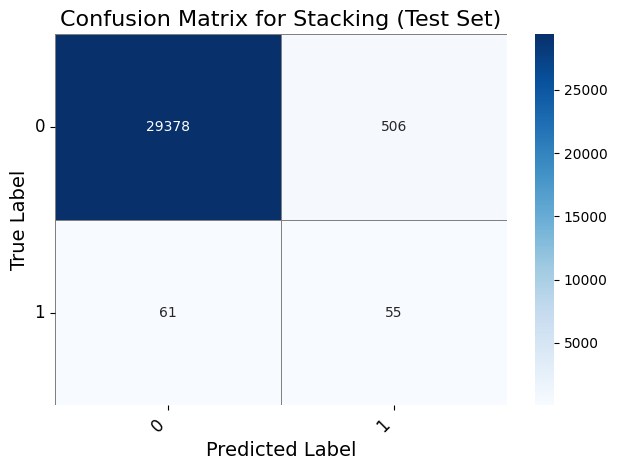

In [37]:
evaluator.plot_confusion_matrix(model_name='Stacking', dataset_name="Test")

#### XGBoost

In [38]:
y_testpred_xgb = xgb_model.predict(X_test)
y_testpred_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
evaluator.evaluate_model(
    model_name="XGBoost",
    y_actual=y_test,
    y_pred=y_testpred_xgb,
    y_pred_prob=y_testpred_prob_xgb,
    dataset_name="Test"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
XGBoost,0.9763,0.079208,0.482759,0.136087,0.942418,0.098283


#### AdaBoost

In [39]:
y_testpred_adaboost = adaboost_model.predict(X_test)
y_testpred_prob_adaboost = adaboost_model.predict_proba(X_test)[:, 1]

evaluator.evaluate_model(
    model_name="AdaBoost",
    y_actual=y_test,
    y_pred=y_testpred_adaboost,
    y_pred_prob=y_testpred_prob_adaboost,
    dataset_name="Test"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
AdaBoost,0.973733,0.072519,0.491379,0.126386,0.939294,0.103572


### All Models on Test

In [40]:
evaluator.display_results(dataset_name="Test")

,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
0,Baseline Model 1,0.499367,0.003796,0.491379,0.007533,0.500000,0.003867
1,Baseline Model 2,0.996133,0.000000,0.000000,0.000000,0.500000,0.003867
2,GaussianNB,0.994667,0.041667,0.017241,0.024390,0.603841,0.006928
3,DecisionTree,0.966133,0.031250,0.258621,0.055762,0.819146,0.049176
4,HistGB,0.983900,0.121649,0.508621,0.196339,0.938990,0.125583
5,RandomForest,0.967700,0.031833,0.250000,0.056475,0.915148,0.061698
6,Voting,0.985733,0.126794,0.456897,0.198502,0.931907,0.124500
7,Stacking,0.981100,0.098039,0.474138,0.162482,0.794737,0.056752
8,XGBoost,0.976300,0.079208,0.482759,0.136087,0.942418,0.098283
9,AdaBoost,0.973733,0.072519,0.491379,0.126386,0.939294,0.103572


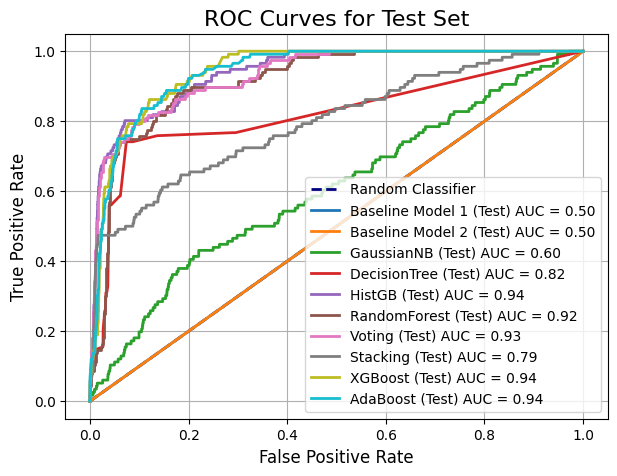

In [41]:
evaluator.plot_curves(curve_type='roc', dataset_name="Test")

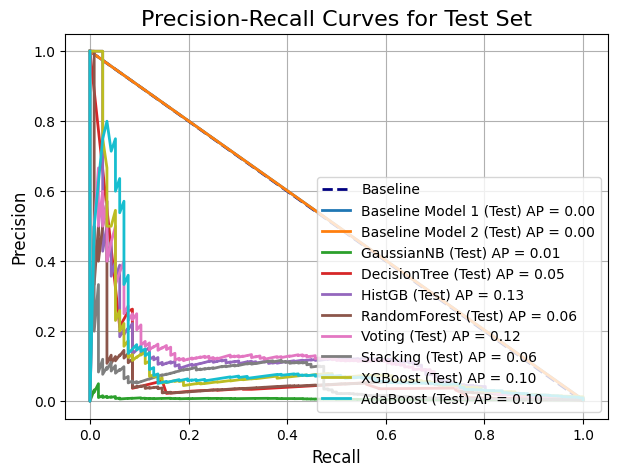

In [42]:
evaluator.plot_curves(curve_type='precision_recall', dataset_name="Test")